In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms#, datasets
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

print("Done")

Done


In [2]:
# Dataset and Annotations
input_directory = "..\\o_npy_resized" #244x244 npy files
annotations_path = "gender_annotations.csv"

In [3]:
# Seed
torch.manual_seed(627726)

In [7]:
# Dataset Class
class GenderDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.annotations) #7211
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = np.load(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [9]:
# Create Dataset
dts = GenderDataset(csv_file=annotations_path, root_dir=input_directory, transform=transforms.ToTensor())

In [10]:
num_male = 0
num_female = 0
for i in dts:
    if i[1].item() == 1:
        num_male += 1
    else:
        num_female += 1

print(num_male)
print(num_female)

2529
4682


In [11]:
# Create Test and Train Data
train_size = int(len(dts) * 0.8)
test_size = len(dts) - train_size

train_data, test_data = torch.utils.data.random_split(dts, [train_size, test_size])

In [17]:
# Model Outline
"""
# Create small batchsize for images
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Define CNN Model
# CNN Layer 1
conv1  = nn.Conv2d(1, 32, 3, 1) 
# CNN Layer 2
conv2 = nn.Conv2d(32, 64, 3, 1)
# CNN Layer 2
conv3 = nn.Conv2d(64, 128, 3, 1)

# Grab 1 datapoint
for i, (X_train, y_train) in enumerate(train_data):
    break

# View grabbed data
X_train.shape
#    torch.Size([1,224,224])

# set to 4d batch
# First param is batch size, it's only 1 for now
x = X_train.view(1,1,224,224)

# Perform Convolution
x = F.relu(conv1(x))
x.shape
#    torch.Size([1,32,222,222])

# Pooling Layer
x = F.max_pool2d(x, 2, 2)
#print(x.shape)
#    torch.Size([1,32,111,111])

# Perform Convolution 2
x = F.relu(conv2(x))
#print(x.shape)
# Padding results in dimension loss
#    torch.Size([1,64,109,109])

# Pooling Layer 2
x = F.max_pool2d(x, 2, 2)
#print(x.shape)
#    torch.Size([1,64,54,54])

# Perform Convolution 3
x = F.relu(conv3(x))
print(x.shape)
# Padding results in dimension loss
#    torch.Size([1,128,52,52])

# Pooling Layer 3
x = F.max_pool2d(x, 2, 2)
print(x.shape)
#    torch.Size([1,128,26,26])
"""

"\n# Create small batchsize for images\ntrain_loader = DataLoader(train_data, batch_size=32, shuffle=True)\ntest_loader = DataLoader(test_data, batch_size=32, shuffle=False)\n\n# Define CNN Model\n# CNN Layer 1\nconv1  = nn.Conv2d(1, 32, 3, 1) \n# CNN Layer 2\nconv2 = nn.Conv2d(32, 64, 3, 1)\n# CNN Layer 2\nconv3 = nn.Conv2d(64, 128, 3, 1)\n\n# Grab 1 datapoint\nfor i, (X_train, y_train) in enumerate(train_data):\n    break\n\n# View grabbed data\nX_train.shape\n#    torch.Size([1,224,224])\n\n# set to 4d batch\n# First param is batch size, it's only 1 for now\nx = X_train.view(1,1,224,224)\n\n# Perform Convolution\nx = F.relu(conv1(x))\nx.shape\n#    torch.Size([1,32,222,222])\n\n# Pooling Layer\nx = F.max_pool2d(x, 2, 2)\n#print(x.shape)\n#    torch.Size([1,32,111,111])\n\n# Perform Convolution 2\nx = F.relu(conv2(x))\n#print(x.shape)\n# Padding results in dimension loss\n#    torch.Size([1,64,109,109])\n\n# Pooling Layer 2\nx = F.max_pool2d(x, 2, 2)\n#print(x.shape)\n#    torch.Size

In [6]:
# Model Class
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) 
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)

        self.dp1 = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(26*26*128, 2)

    def forward(self, X):
        # Basically what we did in the previous step
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)

        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)

        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,2,2)

        # Flatten Data
        # input is -1 to automatically infer batch size, this means we can have a varying batch size
        # output is the number of features
        X = X.view(-1, 26*26*128)

        # Dropout
        X = self.dp1(X)
        
        # FC Layers
        X = self.fc1(X)

        return X #F.log_softmax(X, dim=1)

In [9]:
# Create Model
model = CNN()
model

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dp1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=86528, out_features=2, bias=True)
)

In [10]:
# Loss Function optimizer
criterion = nn.CrossEntropyLoss()
# lr is learning rate, smaller is slower but better, higher is faster but worse
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
import time
start_time = time.time()

# Define Tracking Vars
# Number of times to train and test
epochs = 8
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# Train and Test Loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Loop of Epochs
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    model.train()

    # Train
    running_train_loss = 0.0
    for b,(X_train, y_train) in enumerate(train_loader):
        b += 1 #start batches at 1
        y_pred = model(X_train) # get predicted values from training set. 2D not flat
        loss = criterion(y_pred, y_train) # How wrong is the prediction

        predicted = torch.max(y_pred.data, 1)[1] # add up the number of crrect prediction
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track Loss
        running_train_loss += loss.item()

        # Print Results
        if b%10 == 0:
            print(f"Epoch: {i} Batch: {b} Loss: {loss.item()} Time: {time.time() - start_time}")

    train_losses.append(running_train_loss/len(train_loader))
    train_correct.append(trn_corr)
    print(f"Epoch: {i} Avg Loss: {running_train_loss/len(train_loader)} Time: {time.time() - start_time}")

    # Test
    # No gradient
    # Don't update weight or biases
    running_test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for b,(X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

            # Track Loss
            loss = criterion(y_val, y_test)
            running_test_loss += loss.item()

        #loss = criterion(y_val, y_test)
        test_losses.append(running_test_loss/len(test_loader))
        test_correct.append(tst_corr)


current_time = time.time()
total = current_time - start_time

print(f"Training Took: {total} seconds!")

Epoch: 0 Batch: 10 Loss: 0.6647143959999084 Time: 6.014780521392822
Epoch: 0 Batch: 20 Loss: 0.6064879894256592 Time: 12.147477865219116
Epoch: 0 Batch: 30 Loss: 0.7176305055618286 Time: 18.059857845306396
Epoch: 0 Batch: 40 Loss: 0.590745747089386 Time: 24.037987232208252
Epoch: 0 Batch: 50 Loss: 0.6682958006858826 Time: 29.94554114341736
Epoch: 0 Batch: 60 Loss: 0.6377497315406799 Time: 36.10826349258423
Epoch: 0 Batch: 70 Loss: 0.7085874080657959 Time: 42.02179312705994
Epoch: 0 Batch: 80 Loss: 0.5614718794822693 Time: 47.82879376411438
Epoch: 0 Batch: 90 Loss: 0.641891360282898 Time: 53.744943141937256
Epoch: 0 Batch: 100 Loss: 0.5501769185066223 Time: 59.73637056350708
Epoch: 0 Batch: 110 Loss: 0.5638635158538818 Time: 65.6407196521759
Epoch: 0 Batch: 120 Loss: 0.5357283353805542 Time: 71.524822473526
Epoch: 0 Batch: 130 Loss: 0.6426414251327515 Time: 77.5484664440155
Epoch: 0 Batch: 140 Loss: 0.6454265713691711 Time: 83.51731157302856
Epoch: 0 Batch: 150 Loss: 0.6728129982948303 

In [18]:
# Train Losses to Float
#train_losses = [tl.item() for tl in train_losses]
test_losses = [tl/len(test_loader) for tl in test_losses]

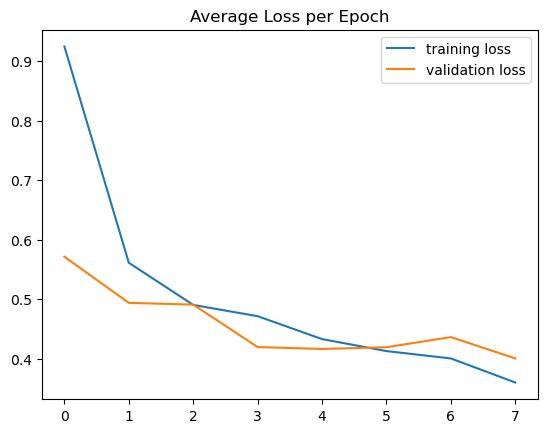

In [21]:
# Graphing
plt.plot(train_losses, label="training loss")
plt.plot(test_losses, label="validation loss")
plt.title("Average Loss per Epoch")
plt.legend()
plt.savefig("gender_estimation_loss_plot.png")
plt.show()

In [23]:
# Save Loss Data
combined = np.column_stack((train_losses, test_losses))

# Save to CSV
np.savetxt("o_avg_loss.csv", combined, delimiter=",", header="Training Loss,Test Loss", comments='', fmt='%s')

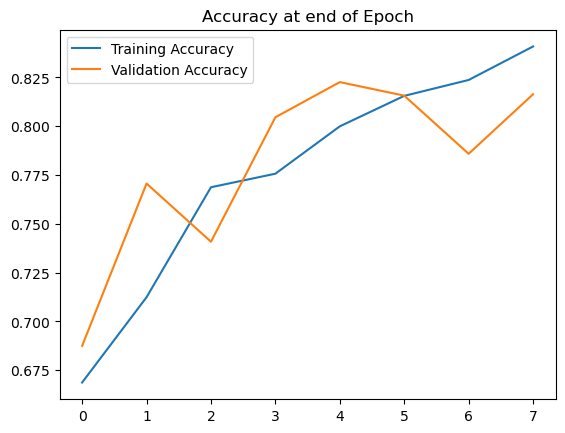

In [22]:
# Graph Accuracy at end of each Epoch
plt.plot([t/train_size for t in train_correct], label="Training Accuracy")
plt.plot([t/test_size for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at end of Epoch")
plt.legend()
plt.savefig("gender_estimation_accuracy_plot.png")
plt.show()

In [24]:
# Save Loss Data
combined = np.column_stack(([t/train_size for t in train_correct], [t/test_size for t in test_correct]))

# Save to CSV
np.savetxt("o_acc.csv", combined, delimiter=",", header="Training Acc,Test Acc", comments='', fmt='%s')

In [25]:
# Save Model
torch.save(model.state_dict(), "epochs_finale_8_dp.pt")

In [18]:
# Grab an image
my_index = 456
test_data[my_index][1] # This is the label, ie it's classification
#test_data[my_index][0] # image in numpy format

tensor(1)

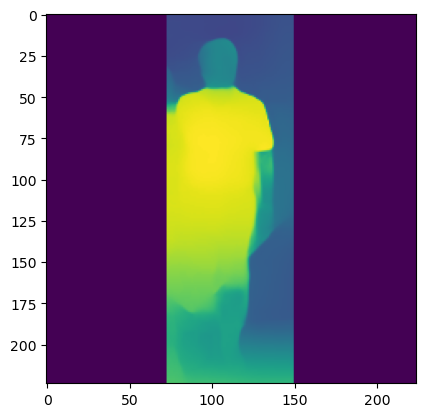

In [19]:
#Show image
plt.imshow(test_data[my_index][0].reshape(224,224))
plt.show()

In [20]:
# Evaluate Grabbed Datapoint
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[my_index][0].view(1,1,224,224)) # Batch size of 1, 1 channel, 28x28

new_prediction.argmax()

tensor(0)

In [ ]:
# Evaluate Grabbed Datapoint
new_model.eval()
with torch.no_grad():
    new_prediction = new_model(test_data[my_index][0].view(1,1,224,224)) # Batch size of 1, 1 channel, 28x28

new_prediction.argmax()

In [7]:
# Load Model
new_model = CNN()
new_model.load_state_dict(torch.load("epochs_finale_8_dp.pt"))

C:\Users\johny\AppData\Local\Temp\ipykernel_19020\1464521245.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load("epochs_finale_8_dp.pt"

<All keys matched successfully>

In [20]:
# Evaluate Grabbed Datapoint
new_model.eval()
with torch.no_grad():
    new_prediction = new_model(test_data[my_index][0].view(1,1,224,224)) # Batch size of 1, 1 channel, 28x28

new_prediction.argmax()

tensor(1)